## Crop Classification

#### Visualization of spation temporal input and expected outputs for crop type prediction models

# Crop type prediction Using 3d Unet

In [1]:
import tensorflow as tf
import keras
print(tf.__version__)
print(keras.__version__)
from keras.models import load_model

from scipy.stats import mode


2024-07-15 13:39:58.544387: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-15 13:39:59.778100: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-15 13:40:02.724260: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.13.1
2.13.1


In [2]:
#Make sure the GPU is available. 
import tensorflow as tf
device_name = tf.test.gpu_device_name()

2024-07-15 13:40:16.547469: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-15 13:40:16.548972: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-15 13:40:17.039062: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
#Make sure the GPU is available. 
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


2024-07-15 13:40:18.261013: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-15 13:40:18.262506: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-15 13:40:18.265448: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
import segmentation_models_3D as sm
from skimage import io
from patchify import patchify, unpatchify
import numpy as np
from matplotlib import pyplot as plt
from keras import backend as K
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

Segmentation Models: using `tf.keras` framework.


## Vista Crop Types

In [5]:

vista_crop_dict = { 0:'NA' , 1: 'ALFALFA', 2: 'BEET', 3: 'CLOVER', 4: 'FLAX', 5: 'FLOWERING_LEGUMES', 6: 'FLOWERS', 7: 'FOREST', 8: 'GRAIN_MAIZE', 9: 'GRASSLAND', 10: 'HOPS', 11: 'LEGUMES', 12: 'VISTA_NA', 13: 'PERMANENT_PLANTATIONS', 14: 'PLASTIC', 15: 'POTATO', 16: 'PUMPKIN', 17: 'RICE', 18: 'SILAGE_MAIZE', 19: 'SOY', 20: 'SPRING_BARLEY', 21: 'SPRING_OAT', 22: 'SPRING_OTHER_CEREALS', 23: 'SPRING_RAPESEED', 24: 'SPRING_RYE', 25: 'SPRING_SORGHUM', 26: 'SPRING_SPELT', 27: 'SPRING_TRITICALE', 28: 'SPRING_WHEAT', 29: 'SUGARBEET', 30: 'SUNFLOWER', 31: 'SWEET_POTATOES', 32: 'TEMPORARY_GRASSLAND', 33: 'WINTER_BARLEY', 34: 'WINTER_OAT', 35: 'WINTER_OTHER_CEREALS', 36: 'WINTER_RAPESEED', 37: 'WINTER_RYE', 38: 'WINTER_SORGHUM', 39: 'WINTER_SPELT', 40: 'WINTER_TRITICALE', 41: 'WINTER_WHEAT'}

chosen_crop_types_list_list = [[1, 2, 3], [4, 5, 7], [8,  9, 10], [11, 12, 13], [14, 15, 16], [18, 19, 20], [21, 23, 27], [28, 30, 32], [33, 34, 35], [36, 37, 40], [37, 40, 41]]


In [7]:
all_test_ground_truth = []
all_test_prediction = []

for chosen_crop_types_list_indata in chosen_crop_types_list_list:
    for test_img_number in range(30):
        ground_truth = io.imread('/home/luser/stelar_3dunet/ensamble_results/iou_f1/ground_truth_'+str(test_img_number)+'_contains'+vista_crop_dict[chosen_crop_types_list_indata[0]]+'_'+vista_crop_dict[chosen_crop_types_list_indata[1]]+'_'+vista_crop_dict[chosen_crop_types_list_indata[2]]+'_.tif')
        prediction = io.imread('/home/luser/stelar_3dunet/ensamble_results/iou_f1/prediction_'+str(test_img_number)+'_contains'+vista_crop_dict[chosen_crop_types_list_indata[0]]+'_'+vista_crop_dict[chosen_crop_types_list_indata[1]]+'_'+vista_crop_dict[chosen_crop_types_list_indata[2]]+'_.tif')
        all_test_ground_truth.append(ground_truth)
        all_test_prediction.append(prediction)        
        print("ground_truth.shape", ground_truth.shape)
        print("prediction.shape", prediction.shape)

all_test_ground_truth = np.array(all_test_ground_truth)
all_test_prediction = np.array(all_test_prediction)

ground_truth.shape (64, 64)
prediction.shape (64, 64)
ground_truth.shape (64, 64)
prediction.shape (64, 64)
ground_truth.shape (64, 64)
prediction.shape (64, 64)
ground_truth.shape (64, 64)
prediction.shape (64, 64)
ground_truth.shape (64, 64)
prediction.shape (64, 64)
ground_truth.shape (64, 64)
prediction.shape (64, 64)
ground_truth.shape (64, 64)
prediction.shape (64, 64)
ground_truth.shape (64, 64)
prediction.shape (64, 64)
ground_truth.shape (64, 64)
prediction.shape (64, 64)
ground_truth.shape (64, 64)
prediction.shape (64, 64)
ground_truth.shape (64, 64)
prediction.shape (64, 64)
ground_truth.shape (64, 64)
prediction.shape (64, 64)
ground_truth.shape (64, 64)
prediction.shape (64, 64)
ground_truth.shape (64, 64)
prediction.shape (64, 64)
ground_truth.shape (64, 64)
prediction.shape (64, 64)
ground_truth.shape (64, 64)
prediction.shape (64, 64)
ground_truth.shape (64, 64)
prediction.shape (64, 64)
ground_truth.shape (64, 64)
prediction.shape (64, 64)
ground_truth.shape (64, 64)


In [9]:
all_test_ground_truth.shape, all_test_prediction.shape

((330, 64, 64), (330, 64, 64))

## Quantitative Analysis : Crop prediction

### Sampled training data analysis

In [12]:
crop_types_all_list = [ 1,  2,  3,  4,  5,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 20, 21, 23, 27, 28, 30, 32, 33, 34, 35, 36, 37, 40, 41]


In [10]:
unique_elements, element_counts = np.unique(all_test_ground_truth, return_counts=True)


total_elements = np.sum(element_counts)
element_percentages = (element_counts / total_elements) * 100

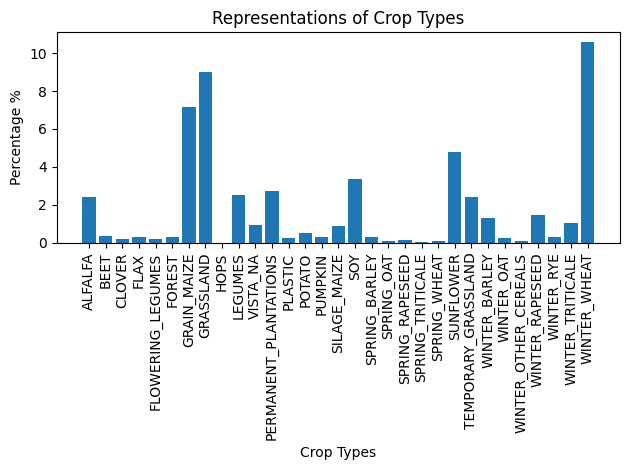

In [11]:
# Plotting
crop_types = [vista_crop_dict[element] for element in unique_elements]

# Plotting
plt.bar(crop_types[1:], element_percentages[1:])
plt.xlabel('Crop Types')
plt.ylabel('Percentage %')
plt.title('Representations of Crop Types')
plt.xticks(rotation=90)  # Rotate labels vertically
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [46]:

# give a number between 0 and 256: len(X_test) as input to the function
def get_label_and_prediction(test_img_number):

    test_img = X_test[test_img_number-1]

    ground_truth_1 = y_test_1[test_img_number-1]
    ground_truth_2 = y_test_2[test_img_number-1]
    ground_truth_3 = y_test_3[test_img_number-1]    

    ground_truth_argmax_1 = np.argmax(ground_truth_1, axis=3);
    ground_truth_argmax_2 = np.argmax(ground_truth_2, axis=3);
    ground_truth_argmax_3 = np.argmax(ground_truth_3, axis=3);

    test_img_input=np.expand_dims(test_img, 0);
    test_img_input1 = preprocess_input(test_img_input);

    test_pred1 = my_model_1.predict(test_img_input1);
    test_pred2 = my_model_2.predict(test_img_input1);
    test_pred3 = my_model_3.predict(test_img_input1);

    test_prediction1 = np.argmax(test_pred1, axis=4)[0,:,:,:];
    test_prediction2 = np.argmax(test_pred2, axis=4)[0,:,:,:];
    test_prediction3 = np.argmax(test_pred3, axis=4)[0,:,:,:];

    test_prediction1[test_prediction1==0]=0
    test_prediction1[test_prediction1==1]=11
    test_prediction1[test_prediction1==2]=13
    test_prediction1[test_prediction1==3]=32

    test_prediction2[test_prediction2==0]=0
    test_prediction2[test_prediction2==1]=9
    test_prediction2[test_prediction2==2]=11
    test_prediction2[test_prediction2==3]=13

    test_prediction3[test_prediction3==0]=0
    test_prediction3[test_prediction3==1]=1
    test_prediction3[test_prediction3==2]=7
    test_prediction3[test_prediction3==3]=8

    ground_truth_argmax_1[ground_truth_argmax_1==0]=0
    ground_truth_argmax_1[ground_truth_argmax_1==1]=11
    ground_truth_argmax_1[ground_truth_argmax_1==2]=13
    ground_truth_argmax_1[ground_truth_argmax_1==3]=32

    ground_truth_argmax_2[ground_truth_argmax_2==0]=0
    ground_truth_argmax_2[ground_truth_argmax_2==1]=9
    ground_truth_argmax_2[ground_truth_argmax_2==2]=11
    ground_truth_argmax_2[ground_truth_argmax_2==3]=13
 
    ground_truth_argmax_3[ground_truth_argmax_3==0]=0
    ground_truth_argmax_3[ground_truth_argmax_3==1]=1
    ground_truth_argmax_3[ground_truth_argmax_3==2]=7
    ground_truth_argmax_3[ground_truth_argmax_3==3]=8

    result_image1 = np.median(test_prediction1, axis=0).astype(np.uint8)
    ground_truth_image1 = np.median(ground_truth_argmax_1, axis=0).astype(np.uint8)


    result_image2 = np.median(test_prediction2, axis=0).astype(np.uint8)
    ground_truth_image2 = np.median(ground_truth_argmax_2, axis=0).astype(np.uint8)


    result_image3 = np.median(test_prediction3, axis=0).astype(np.uint8)
    ground_truth_image3 = np.median(ground_truth_argmax_3, axis=0).astype(np.uint8)

    ensambled_ground_truth = np.zeros(ground_truth_image1.shape)
    ensambled_result_image = np.zeros(result_image1.shape)

    #ensambled_ground_truth[ground_truth_image1==0]=0
    ensambled_ground_truth[ground_truth_image1==11]=11
    ensambled_ground_truth[ground_truth_image1==13]=13
    ensambled_ground_truth[ground_truth_image1==32]=32

    #ensambled_ground_truth[ground_truth_image2==0]=0
    ensambled_ground_truth[ground_truth_image2==9]=9
    ensambled_ground_truth[ground_truth_image2==11]=11
    ensambled_ground_truth[ground_truth_image2==13]=13

    #ensambled_ground_truth[ground_truth_image3==0]=0
    ensambled_ground_truth[ground_truth_image3==1]=1
    ensambled_ground_truth[ground_truth_image3==7]=7
    ensambled_ground_truth[ground_truth_image3==8]=8


    #ensambled_result_image[result_image1==0]=0
    ensambled_result_image[result_image1==11]=11
    ensambled_result_image[result_image1==13]=13
    ensambled_result_image[result_image1==32]=32

    #ensambled_result_image[result_image2==0]=0
    ensambled_result_image[result_image2==9]=9
    ensambled_result_image[result_image2==11]=11
    ensambled_result_image[result_image2==13]=13

    #ensambled_result_image[result_image3==0]=0
    ensambled_result_image[result_image3==1]=1
    ensambled_result_image[result_image3==7]=7
    ensambled_result_image[result_image3==8]=8

    return ensambled_ground_truth, ensambled_result_image



In [47]:
from sklearn.metrics import jaccard_score, f1_score, accuracy_score

In [48]:
len(X_test)

256

In [49]:
# For permanent plantations no: 13 in the test set
all_crops_iou_distributions = []
for unique in unique_elements[1:]:
    each_iou_distribution = []
    for i in range(len(X_test)):
        ground_truth, prediction = get_label_and_prediction(i);

        ground_truth[ground_truth!=unique]=0
        prediction[prediction!=unique]=0
        
        iou = jaccard_score(ground_truth, prediction, average='macro');
        
        each_iou_distribution.append(iou)
        #print("Intersection over union", iou)
    all_crops_iou_distributions.append(each_iou_distribution);

1/1 [==============================] - 0s 294ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 301ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 280ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 309ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 291ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 273ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 280ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 265ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 275ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 232ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 268ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 279ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 278ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 273ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 280ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 269ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 254ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 269ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 279ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 264ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 260ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 265ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 256ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 288ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 267ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 261ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 279ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 265ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 288ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 262ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 292ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 265ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 281ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 246ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 286ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 269ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 260ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 268ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 284ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 268ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 263ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 300ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 271ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 291ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 287ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 262ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 276ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 310ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 301ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 269ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 281ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 242ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 264ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 273ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 283ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 286ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 270ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 253ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 270ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 278ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 260ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 266ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 259ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 270ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 256ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 258ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 278ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 275ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 275ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 278ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 279ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 258ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 253ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 259ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 283ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 278ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 247ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 275ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 271ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 259ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 254ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 263ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 254ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 271ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 287ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 302ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 302ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 245ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 283ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 260ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 284ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 261ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 263ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 283ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 283ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 276ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 300ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 273ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 271ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 261ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 285ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 266ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 257ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 283ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 277ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 270ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 295ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 267ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 264ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 262ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 280ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 266ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 271ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 279ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 283ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 291ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 280ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 272ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 254ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 267ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 279ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 269ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 314ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 285ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 277ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 275ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 283ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 280ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 267ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 271ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 261ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 265ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 280ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 280ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 277ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 252ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 265ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 269ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 279ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 289ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 278ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 283ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 290ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 270ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 277ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 273ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 257ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 276ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 262ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 281ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 266ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 291ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 272ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 282ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 278ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 255ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 278ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 250ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 278ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 278ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 290ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 280ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 259ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 279ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 274ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 274ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 269ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 282ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 274ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 258ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 270ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 268ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 281ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 274ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 272ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 275ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 265ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 279ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 276ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 311ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 280ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 259ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 270ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 253ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 274ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 272ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 262ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 242ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 260ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 276ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 328ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 271ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 323ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 275ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 249ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 279ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 265ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 263ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 278ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 278ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 281ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 276ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 272ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 287ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 261ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 275ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 274ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 255ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 272ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 287ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 250ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 268ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 271ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 274ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 264ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 276ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 286ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 295ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 271ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 275ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 268ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 267ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 282ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 285ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 261ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 280ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 283ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 279ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 285ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 258ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 282ms/step


/home/luser/anaconda3/envs/stlr3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in labels with no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 [==============================] - 0s 260ms/step


In [ ]:
len(all_crops_iou_distributions), len(all_crops_iou_distributions[0]), len(all_crops_iou_distributions[2])

(7, 256, 256)

## Intersection Over Union

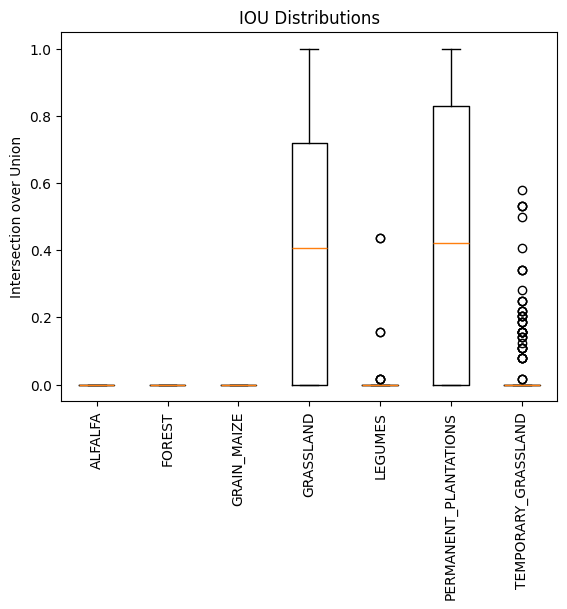

In [ ]:
import matplotlib.pyplot as plt

data = all_crops_iou_distributions
# Creating box plot
plt.boxplot(data)

crop_types = [vista_crop_dict[element] for element in unique_elements]

plt.xticks(range(1, len(data) + 1), crop_types[1:], rotation=90)
# Adding title and labels
plt.title('IOU Distributions')
#plt.xlabel('Distribution')
plt.ylabel('Intersection over Union')

# Displaying the plot
plt.show()


## F1 Score

In [ ]:
# For permanent plantations no: 13 in the test set
all_crops_f1_distributions = []
for unique in unique_elements[1:]:
    each_iou_distribution = []
    for i in range(len(X_test)):
        ground_truth, prediction = get_label_and_prediction(i);

        ground_truth[ground_truth!=unique]=0
        prediction[prediction!=unique]=0
        
        f1 = f1_score(ground_truth, prediction, average='macro')
        
        each_iou_distribution.append(f1)
        #print("Intersection over union", iou)
    all_crops_f1_distributions.append(each_iou_distribution);

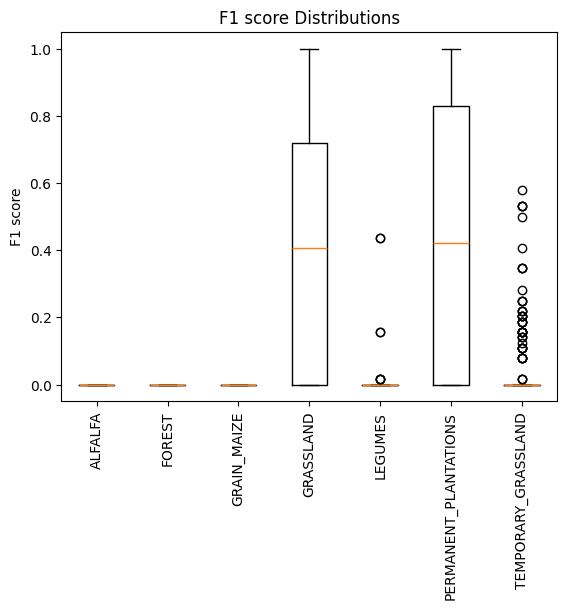

In [ ]:
import matplotlib.pyplot as plt

data = all_crops_f1_distributions
# Creating box plot
plt.boxplot(data)

crop_types = [vista_crop_dict[element] for element in unique_elements]

plt.xticks(range(1, len(data) + 1), crop_types[1:], rotation=90)
# Adding title and labels
plt.title('F1 score Distributions')
#plt.xlabel('Distribution')
plt.ylabel('F1 score')

# Displaying the plot
plt.show()


# Trials with Convolutional LSTM 

In [15]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.plugins import DDPPlugin
from pathlib import Path
from utils.PAD_datamodule import PADDataModule
from model.PAD_convLSTM_backup import ConvLSTM
from utils.settings.config import LINEAR_ENCODER, CLASS_WEIGHTS, BANDS

import numpy as np
import matplotlib.pyplot as plt

In [2]:

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("CUDA is available. Using GPU.")
else:
    device = torch.device("cpu")
    print("CUDA is not available. Using CPU.")

CUDA is available. Using GPU.


In [3]:

# Set seed for everything
pl.seed_everything(42)  # Use a specific seed for reproducibility

# Normalize paths for different OSes
root_path_coco = Path('coco_files/')  # Adjust the path as needed
netcdf_path = Path('dataset/netcdf/')  # Adjust the path as needed

Global seed set to 42


In [4]:

# Create Data Module
dm = PADDataModule(
    netcdf_path=netcdf_path,
    path_train=root_path_coco / '20240220190606_coco_train.json',
    path_val=root_path_coco / '20240220190606_coco_val.json',
    group_freq='1MS',
    bands=['B02', 'B03', 'B04', 'B08'],
    linear_encoder=LINEAR_ENCODER,
    saved_medians=True,
    window_len=6,
    fixed_window=True,
    requires_norm=True,
    return_masks=False,
    clouds=False,
    cirrus=False,
    shadow=False,
    snow=False,
    output_size=(366, 366),
    batch_size=4,
    num_workers=16,
    binary_labels=False,
    return_parcels=False
)

/home/luser/S4A-Models/sentimod/lib/python3.10/site-packages/pytorch_lightning/core/datamodule.py:149: LightningDeprecationWarning: DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.
  rank_zero_deprecation("DataModule property `dims` was deprecated in v1.5 and will be removed in v1.7.")


In [6]:
#another trial


# Model Configuration 
#checkpoint_path = '/home/luser/S4A-Models/logs/convlstm/20240219131342/run_20240219131342/checkpoints/epoch=100-step=1515.ckpt'

checkpoint_path = '/home/luser/S4A-Models/logs/convlstm/20240331012430/run_20240331012430/checkpoints/epoch=294-step=13865.ckpt'

model = ConvLSTM.load_from_checkpoint(
    checkpoint_path,
    map_location=torch.device('cuda'),  # Adjust device as needed
    run_path=Path('/home/luser/S4A-Models/logs/convlstm/20240331012430/run_20240331012430'),
    linear_encoder=LINEAR_ENCODER,
    crop_encoding=None,  # Add crop_encoding if available
    checkpoint_epoch=100
).to(device)

In [8]:

# Setup for multi-GPUs
dm.setup('fit')
check_data = dm.train_dataloader()


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [9]:
tensor1 = next(iter(check_data))


model_input = tensor1['medians'].to(device)
expected_output = tensor1['labels'].to(device)


model_output = model(model_input)

In [10]:
tensor1 = next(iter(check_data))


model_input = tensor1['medians'].to(device)
expected_output = tensor1['labels'].to(device)


model_output = model(model_input)

In [11]:
model_input.shape, model_output.shape, expected_output.shape

(torch.Size([4, 6, 4, 366, 366]),
 torch.Size([4, 12, 366, 366]),
 torch.Size([4, 366, 366]))

In [12]:
argmax_result = torch.argmax(model_output, dim=1)


In [13]:
# Get the colored image here
def get_RGB_image(expected_output):
    groud_truth_image = expected_output
    #groud_truth_image_lai = resized_label_space_reset

    color_map = {
        0: [139, 69, 19],      # Brown
        1: [0, 128, 0],         # Green
        2: [192, 192, 192],      # Silver
        3: [0, 0, 255],          # Blue
        4: [255, 255, 0],        # Yellow
        5: [255, 165, 0],        # Orange
        6: [255, 0, 255],        # Magenta
        7: [0, 255, 255],        # Cyan
        8: [128, 0, 128],        # Violet
        9: [128, 128, 0],        # Olive
        10: [0, 128, 0],         # Dark Green
        11: [128, 0, 0],         # Maroon
        12: [0, 0, 128],         # Navy
        13: [128, 128, 128],     # Gray
        14: [255, 0, 0]
        } 


    # Create color plot
    groud_truth_color_image = np.zeros(groud_truth_image.shape + (3,), dtype=np.uint8)
    #groud_truth_color_image_lai = np.zeros(groud_truth_image_lai.shape + (3,), dtype=np.uint8)
    for i in range(groud_truth_image.shape[0]):
        for j in range(groud_truth_image.shape[1]):
            segment_id_gt = groud_truth_image[i, j]
            #segment_id_gt_lai = groud_truth_image_lai[i, j]
            groud_truth_color_image[i, j] = color_map[segment_id_gt.item()]
            #groud_truth_color_image_lai[i, j] = color_map[segment_id_gt_lai]
    return groud_truth_color_image

In [18]:
expected_output_rgb = []
expected_output_model = []


for i in range(len(expected_output)):
    rgb_image_expected = get_RGB_image(expected_output[i])
    rgb_image_model_out = get_RGB_image(argmax_result[i])
    #print(rgb_image.shape)
    #print("torch.tensor(rgb_image).unsqueeze(0)", torch.tensor(rgb_image).unsqueeze(0).shape)
    expected_output_rgb.append(rgb_image_expected)
    expected_output_model.append(rgb_image_model_out)
        


# Time series image input

<Figure size 640x480 with 0 Axes>

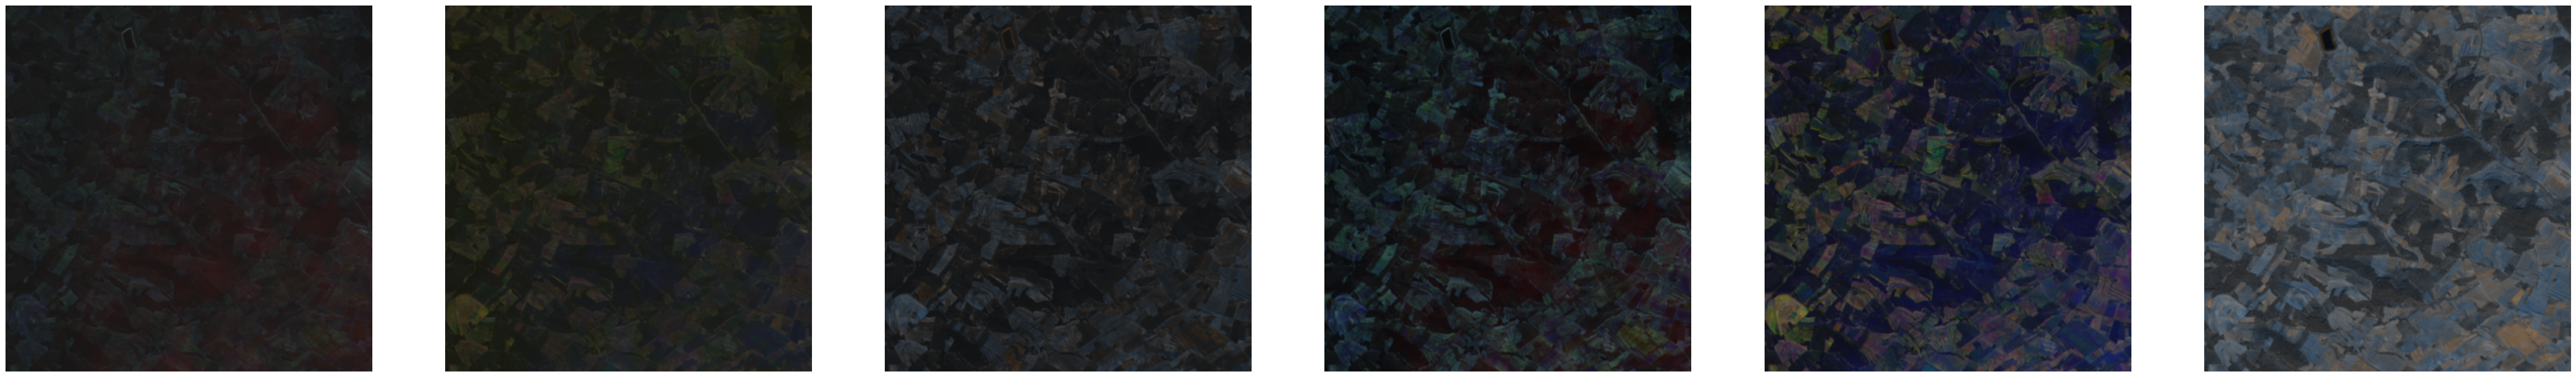

In [27]:
import matplotlib.pyplot as plt
with torch.no_grad():
    plt.suptitle('Time series LAI input')

    fig = plt.figure(figsize=(60,60))

    for i in range(6):
        plt.subplot(1, 6,i+1)
        plt.imshow(model_input[0][i][:3].cpu().numpy().transpose(1, 2, 0))
        plt.axis('off')
    #plt.savefig('input_images.png')
    plt.show()

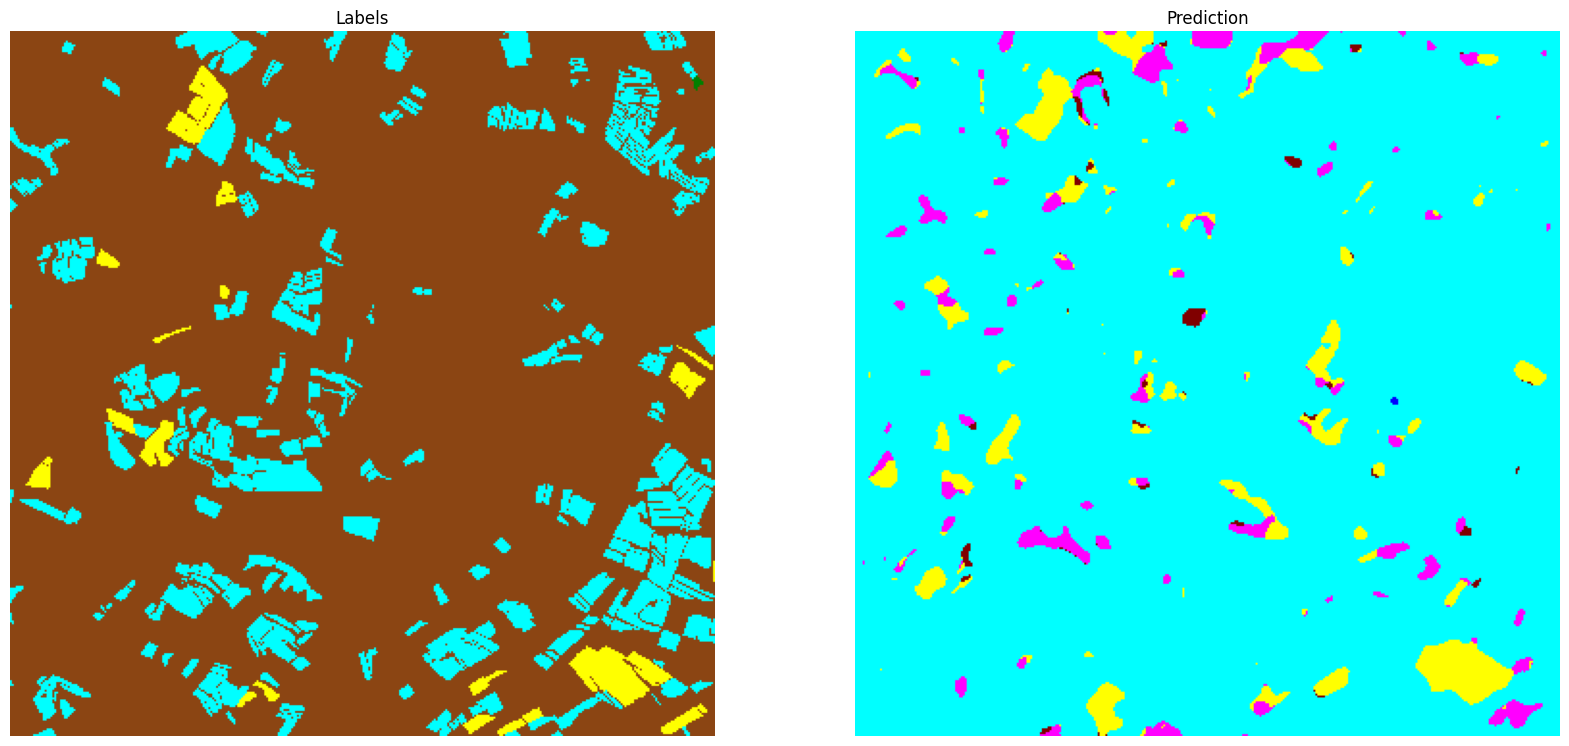

In [30]:
# Plot the first image
with torch.no_grad():
    fig = plt.figure(figsize=(20,10))
    plt.subplot(1, 2, 1)
    plt.title("Labels")
    plt.imshow(expected_output_rgb[0])
    plt.axis('off')

# Plot the second image
with torch.no_grad():
    plt.subplot(1, 2, 2)
    plt.title("Prediction")
    plt.imshow(expected_output_model[0])
    plt.axis('off')

plt.show()

# 2D U-net trials

In [1]:
import numpy as np 
from tensorflow.keras.utils import to_categorical 
from matplotlib import pyplot as plt
import random
from sklearn.model_selection import train_test_split

2024-04-12 10:50:23.007333: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-12 10:50:23.053141: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 10:50:23.770718: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import tensorflow as tf
device = tf.device("/GPU:0" if tf.test.is_gpu_available() else "/CPU:0")


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2024-04-12 10:50:40.894654: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 10:50:40.896326: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 10:50:40.897947: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [4]:
import glob
import tifffile
filepaths = glob.glob('/home/luser/UniBw-STELAR/dataset/france2/processed_lai_npy/*.npy')
filepaths.sort()

In [5]:
filepaths = filepaths[:3]
image_dataset = np.array([])
for file in filepaths:
    img = np.load(file)
    image_dataset = np.append(image_dataset, img)
image_dataset = image_dataset.reshape(-1, 10002, 10002)
labels = np.load('/home/luser/STELAR_Workbenches/saved_labels/lai_specific_france_mask_10_corr.npy')
labels = np.flip(labels, 0 )
labels = labels.reshape(1, 10002, 10002)


In [6]:
patch_len_x = 256
patch_len_y = 256
image_splits = []
label_splits = []
for record in range(image_dataset.shape[0]):
  for ind_i in range(int(image_dataset.shape[1]/patch_len_x)):
    for ind_j in range(int(image_dataset.shape[2]/patch_len_y)):
            selected_patch = image_dataset[record][(ind_i * patch_len_x):((ind_i + 1) * patch_len_x), (ind_j * patch_len_y):((ind_j + 1) * patch_len_y)]
            selected_mask = labels[0][(ind_i * patch_len_x):((ind_i + 1) * patch_len_x), (ind_j * patch_len_y):((ind_j + 1) * patch_len_y)]
            image_splits.append(selected_patch)
            label_splits.append(selected_mask)

image_splits = np.concatenate(image_splits, axis=0)
label_splits = np.concatenate(label_splits, axis=0)

image_splits = image_splits.reshape(-1, patch_len_x, patch_len_y)
label_splits = label_splits.reshape(-1, patch_len_x, patch_len_y)

image_splits = image_splits[:7000]
label_splits = label_splits[:7000]

label_splits = label_splits.reshape(-1, patch_len_x, patch_len_y, 1)
image_splits = image_splits.reshape(-1, patch_len_x, patch_len_y, 1)



In [7]:
total_classes = len(np.unique(label_splits))
label_splits = tf.constant(label_splits)
def _mask_batch_generator(data, batch_size):
    num_samples = data.shape[0]
    num_batches = num_samples // batch_size

    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        batch_data = data[start_idx:end_idx]
        batch_categorical = tf.keras.utils.to_categorical(batch_data, num_classes=total_classes)
        yield batch_categorical


batch_size = 1000
merged_tensor = None

for batch in _mask_batch_generator(label_splits, batch_size):
    if merged_tensor is None:
        merged_tensor = batch
    else:
        merged_tensor = tf.concat([merged_tensor, batch], axis=0)


labels_categorical_dataset = merged_tensor.numpy()
master_trianing_dataset = image_splits[:labels_categorical_dataset.shape[0]]

X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

In [8]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [10]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda
from keras import backend as K


def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value


def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model


metrics = ["accuracy", jaccard_coef]


def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes, 
                          image_height=image_height, 
                          image_width=image_width, 
                          image_channels=image_channels)

model = get_deep_learning_model()

weights = [1/total_classes for i in range(total_classes)]

import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

dice_loss = sm.losses.DiceLoss(class_weights = weights)
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)
tf.keras.backend.clear_session()

model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

import keras
from IPython.display import clear_output
%matplotlib inline

# Loading the model


import keras.backend as K
import segmentation_models as sm

def dice_loss_plus_1focal_loss(y_true, y_pred):
    # Compute dice loss using the DiceLoss class from segmentation_models
    dice_loss = sm.losses.DiceLoss(class_weights=weights)(y_true, y_pred)

    # Compute focal loss using the CategoricalFocalLoss class from segmentation_models
    focal_loss = sm.losses.CategoricalFocalLoss()(y_true, y_pred)

    # Combine the dice loss and focal loss
    total_loss = dice_loss + (1 * focal_loss)

    return total_loss

import keras
from keras import models

# Register the custom loss function
keras.losses.dice_loss_plus_1focal_loss = dice_loss_plus_1focal_loss
keras.metrics.jaccard_coef = jaccard_coef
# Load the saved model
#model = models.load_model('./saved_model/sat_stelar_image_segmentation.h5')
model = models.load_model('/home/luser/stelar/saved_model/sat_stelar_image_segmentation_L1.h5') # 10 classes 7000 sample size Unet convergence


In [11]:
#X_test = X_train
#y_test = y_train
# number between 0 and 600
#test_image_number = 8
def get_2d_unet_plot(test_image_number):
    y_test_argmax = np.argmax(y_test, axis=3)

    test_image = X_test[test_image_number]
    groud_truth_image = y_test_argmax[test_image_number]

    test_image_input = np.expand_dims(test_image, axis=0)

    prediction = (model.predict(test_image_input))
    predicted_image = np.argmax(prediction, axis=-1)
    predicted_image = predicted_image[0,:,:]

    groud_truth_image = groud_truth_image
    predicted_image = predicted_image

    color_map = {
        0: [0, 0, 0],1: [0, 255, 0], 2: [0, 0, 255], 3: [255, 255, 0], 4: [255, 165, 0], 5: [255, 0, 255], 6: [0, 255, 255],   
        7: [128, 0, 128], 8: [128, 128, 0], 9: [0, 128, 0], 10: [128, 0, 0], 11: [0, 0, 128], 12: [128, 128, 128], 13: [0, 128, 128],   
        14: [255, 0, 0], 15: [255, 255, 255], 16: [192, 192, 192], 17: [255, 0, 0], 18: [0, 255, 0], 19: [0, 0, 255], 20: [255, 255, 0],   
        21: [255, 165, 0], 22: [255, 0, 255],  23: [0, 255, 255],  24: [128, 0, 128],  25: [128, 128, 0],  26: [0, 128, 0],     
        27: [128, 0, 0],  28: [0, 0, 128], 29: [128, 128, 128], 30: [0, 128, 128], 31: [0, 0, 0], 32: [255, 255, 255], 
        33: [192, 192, 192], 34: [255, 0, 0], 35: [0, 255, 0], 36: [0, 0, 255], 37: [255, 255, 0], 38: [255, 165, 0], 
        39: [255, 0, 255],  40: [0, 128, 255] }

    groud_truth_color_image = np.zeros(groud_truth_image.shape + (3,), dtype=np.uint8)
    predicted_color_image = np.zeros(predicted_image.shape + (3,), dtype=np.uint8)
    for i in range(groud_truth_image.shape[0]):
        for j in range(groud_truth_image.shape[1]):
            segment_id_gt = groud_truth_image[i, j]
            segment_id_pd = predicted_image[i, j]
            groud_truth_color_image[i, j] = color_map[segment_id_gt]
            predicted_color_image[i, j] = color_map[segment_id_pd]

    plt.figure(figsize=(14, 8))
    plt.subplot(231)
    plt.title('Leaf Area Index (LAI)')
    test_image[test_image<0] = 0
    plt.imshow(test_image)
    plt.subplot(232)
    plt.title('Ground Truth(Crop Types)')
    #plt.imshow(groud_truth_image)
    plt.imshow(groud_truth_color_image)
    plt.subplot(233)
    plt.title('Predicted')
    #plt.imshow(predicted_image)
    plt.imshow(predicted_color_image)

2024-04-12 10:55:14.815206: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8907
2024-04-12 10:55:14.915942: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 2s 2s/step


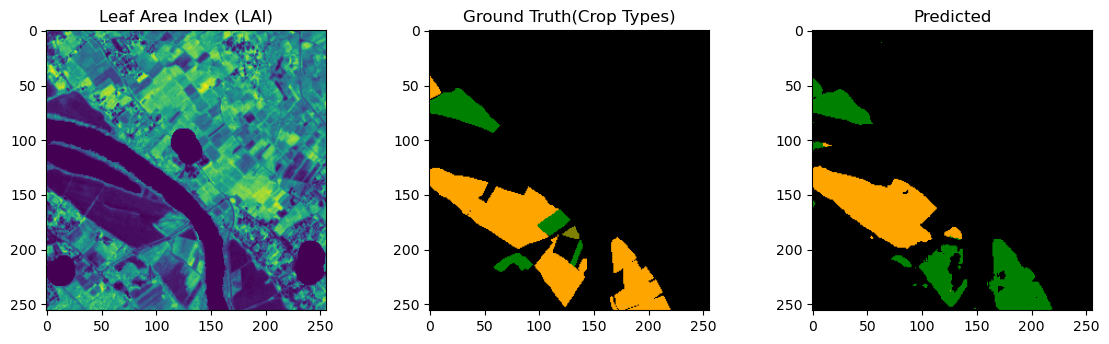

In [12]:
get_2d_unet_plot(8)

1/1 [==============================] - 0s 35ms/step


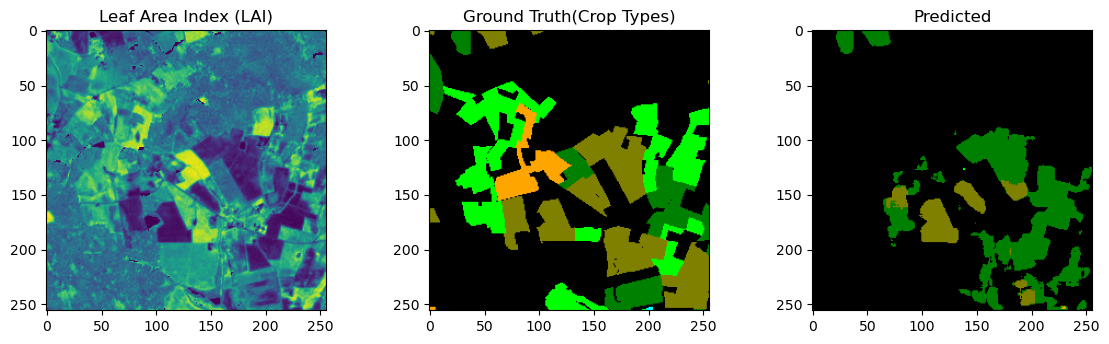

In [13]:
get_2d_unet_plot(122)

1/1 [==============================] - 0s 35ms/step


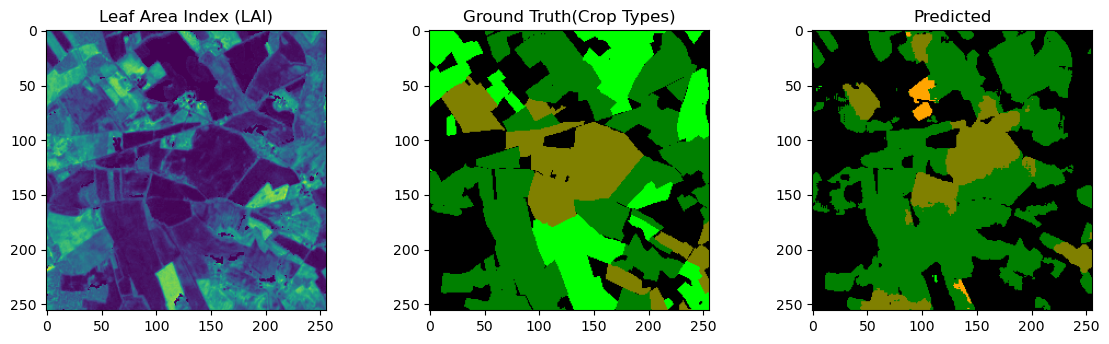

In [16]:
get_2d_unet_plot(158)